<h1>CREAZIONE MODELLO SARIMA REGIONE SICILIA

In [22]:
import pandas as pd
df = pd.read_csv('../../csv/regioni/sicilia.csv')
df.head()

,DATA,TOTALE
0,2015-01-31,5490
1,2015-02-28,5178
2,2015-03-31,5357
3,2015-04-30,4608
4,2015-05-31,4337


In [23]:
df['DATA'] = pd.to_datetime(df['DATA'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    69 non-null     datetime64[ns]
 1   TOTALE  69 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.2 KB


In [25]:
df=df.set_index('DATA')
df.head()

,TOTALE
DATA,
2015-01-31,5490
2015-02-28,5178
2015-03-31,5357
2015-04-30,4608
2015-05-31,4337


<h3>Creazione serie storica dei decessi totali della regione Sicilia

In [26]:
ts = df.TOTALE
ts.head()

DATA
2015-01-31    5490
2015-02-28    5178
2015-03-31    5357
2015-04-30    4608
2015-05-31    4337
Name: TOTALE, dtype: int64

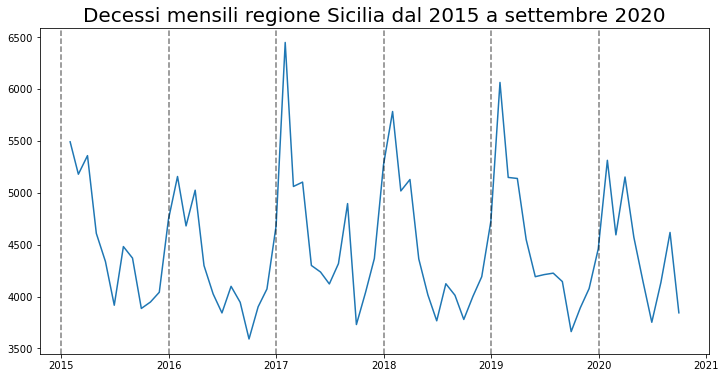

In [27]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,9,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili regione Sicilia dal 2015 a settembre 2020', size=20)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h3>Decomposizione

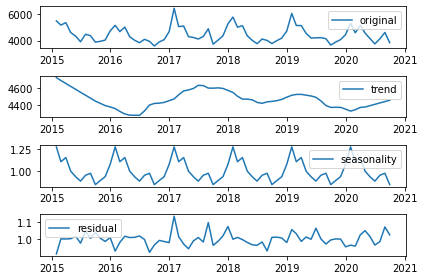

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h3>Test di stazionarietà

In [29]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False
        

In [30]:
test_stationarity(ts)

X is not stationary


False

<h3>Suddivisione in Train e Test

<b>Train</b>: da gennaio 2015 a ottobre 2019; <br />
<b>Test</b>: da ottobre 2019 a dicembre 2019.

In [31]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,9,30)

In [32]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

X is not stationary
X is not stationary
X is not stationary
X is stationary
3


<h3>Grafici di Autocorrelazione e Autocorrelazione Parziale

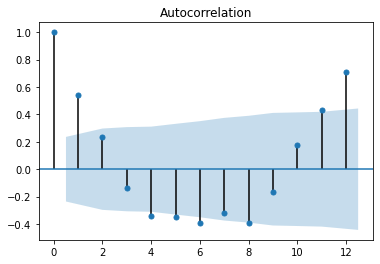

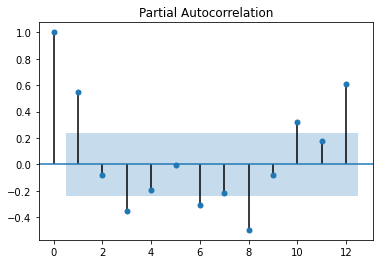

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

<h2>Creazione del modello SARIMA sul Train

In [85]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(6,1,5))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 TOTALE   No. Observations:                   58
Model:               SARIMAX(6, 1, 5)   Log Likelihood                -426.753
Date:                Mon, 08 Mar 2021   AIC                            877.506
Time:                        17:17:55   BIC                            902.023
Sample:                    01-31-2015   HQIC                           887.034
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5501      0.276     -1.995      0.046      -1.091      -0.010
ar.L2         -0.4035      0.365     -1.106      0.269      -1.119       0.312
ar.L3         -0.4406      0.312     -1.413      0.1

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h4>Verifica della stazionarietà dei residui del modello ottenuto

In [86]:
residuals = model_fit.resid
test_stationarity(residuals)

X is stationary


True

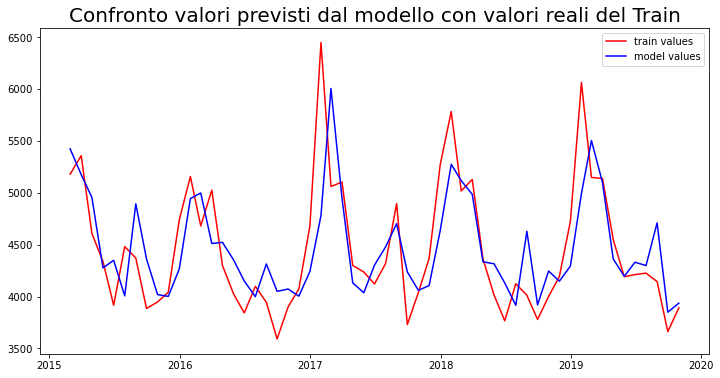

In [87]:
plt.figure(figsize=(12,6))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()

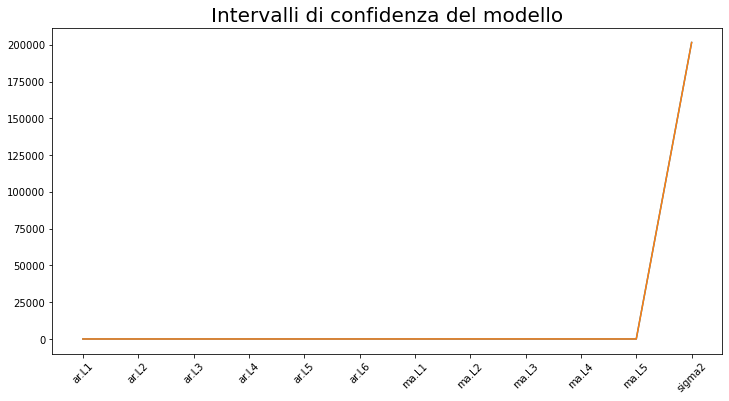

In [88]:
conf = model_fit.conf_int()

plt.figure(figsize=(12,6))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h3>Predizione del modello sul Test

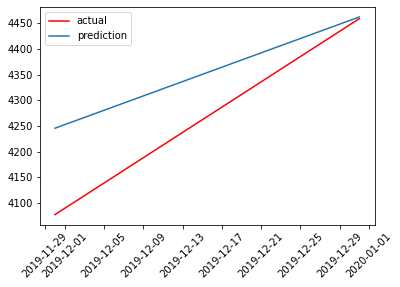

2019-11-30    4245.432404
2019-12-31    4462.264289
Freq: M, Name: predicted_mean, dtype: float64


In [89]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

#pred_start= len(train)
#pred_end = len(tsb)
#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

In [90]:
# Accuracy metrics
import numpy as np
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE: errore percentuale medio assoluto
    me = np.mean(forecast - actual)             # ME: errore medio
    mae = np.mean(np.abs(forecast - actual))    # MAE: errore assoluto medio
    mpe = np.mean((forecast - actual)/actual)   # MPE: errore percentuale medio
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr: correlazione tra effettivo e previsione
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax: errore min-max
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(predictions_test, test)

{'mape': 0.021022448281465485,
 'me': 85.84834652960353,
 'mae': 85.84834652960353,
 'mpe': 0.021022448281465485,
 'rmse': 119.12206003762995,
 'corr': 1.0,
 'minmax': 0.020202662211766143}

In [91]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('NRMSE: %f'% nrmse)

NRMSE: 0.311838


<h2>Predizione del modello compreso l'anno 2020

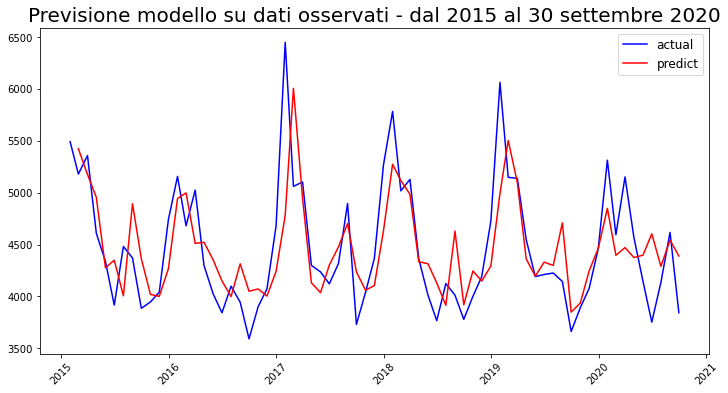

In [92]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 settembre 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

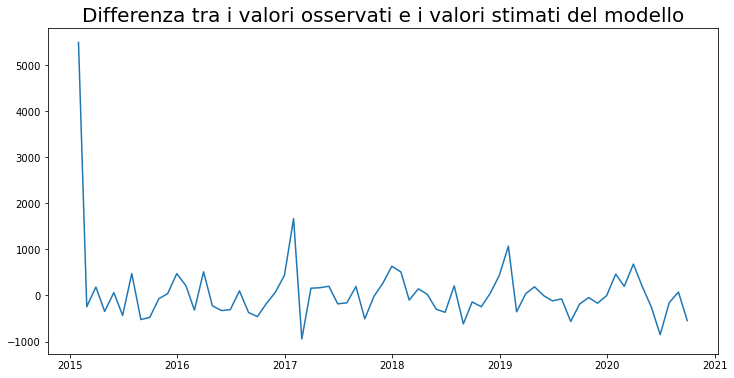

In [93]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [94]:
diff_predictions_tot['24-02-2020':].sum()

-652.1057315927474

In [95]:
predictions_tot.to_csv('../../csv/pred/predictions_SARIMA_sicilia.csv')

In [96]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower TOTALE'])

2015-01-31       0.000000
2015-02-28    5422.508114
2015-03-31    5174.373477
2015-04-30    4954.583785
2015-05-31    4275.374934
                 ...     
2020-05-31    4397.073841
2020-06-30    4602.709781
2020-07-31    4289.598936
2020-08-31    4542.638320
2020-09-30    4389.128571
Freq: M, Name: predicted_mean, Length: 69, dtype: float64
            lower TOTALE  upper TOTALE
2015-01-31  -2282.195639   2282.195639
2015-02-28   4253.674956   6591.341271
2015-03-31   4006.511724   6342.235231
2015-04-30   3798.611609   6110.555960
2015-05-31   3170.256833   5380.493035
...                  ...           ...
2020-05-31   3084.323544   5709.824137
2020-06-30   3279.291821   5926.127741
2020-07-31   2962.514048   5616.683823
2020-08-31   3214.953333   5870.323307
2020-09-30   3061.521573   5716.735569

[69 rows x 2 columns]
2015-01-31    2282.195639
2015-02-28    1168.833157
2015-03-31    1167.861753
2015-04-30    1155.972176
2015-05-31    1105.118101
                 ...     
2020-05-3

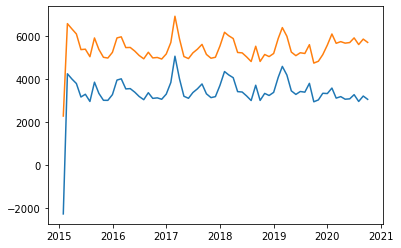

In [97]:
plt.plot(in_c)
plt.show()

In [98]:
upper = in_c['upper TOTALE']
lower = in_c['lower TOTALE']

In [99]:
lower.to_csv('../../csv/lower/predictions_SARIMA_sicilia_lower.csv')
upper.to_csv('../../csv/upper/predictions_SARIMA_sicilia_upper.csv')